# License Plates Recognition

Ivan Martín Campoy (NIU), Aina Navarro Ràfols (1670797), Sara Martín Núñez (1669812)

# _Part III: Optical Character Recognition - KNN testing_

In [120]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import LabelEncoder
import os
import pickle

In [121]:
"""
letter classes = ['B', 'C', 'D', 'F', 'G', 'H', 'J',
           'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T',
            'V', 'W', 'X', 'Y', 'Z']  #these were the classses used, in case label encoder was missing.

number classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']  #these were the classses used, in case label encoder was missing.
"""

label_encoder_numbers_path = 'OCR_models/KNN/label_encoder_numbers.pkl'
label_encoder_letters_path = 'OCR_models/KNN/label_encoder_letters.pkl'

with open(label_encoder_numbers_path, 'rb') as encoder_file:
    label_encoder_numbers = pickle.load(encoder_file)

with open(label_encoder_letters_path, 'rb') as encoder_file:
    label_encoder_letters = pickle.load(encoder_file)

print("LabelEncoders have been loaded successfully.")

letters_number_of_neighbors = 1
numbers_number_of_neighbors = 50

#file paths for KNN models
knn_numbers_model = 'OCR_models/KNN/knn_numbers_model_'+str(numbers_number_of_neighbors)+'.pkl'
knn_letters_model = 'OCR_models/KNN/knn_letters_model_'+str(letters_number_of_neighbors)+'.pkl'

#load KNN Numbers Model
try:
    with open(knn_numbers_model, 'rb') as knn_file:
        knn_numbers = pickle.load(knn_file)
    print(f"KNN Numbers model loaded successfully from {knn_numbers_model}")
except FileNotFoundError:
    print(f"Error: {knn_numbers_model} not found. Please ensure the model is saved correctly.")

#load KNN Letters Model
try:
    with open(knn_letters_model, 'rb') as knn_file:
        knn_letters = pickle.load(knn_file)
    print(f"KNN Letters model loaded successfully from {knn_letters_model}")
except FileNotFoundError:
    print(f"Error: {knn_letters_model} not found. Please ensure the model is saved correctly.")
print(f"({knn_numbers} and {knn_letters}) have been loaded successfully.")


LabelEncoders have been loaded successfully.
Error: OCR_models/KNN/knn_numbers_model_50.pkl not found. Please ensure the model is saved correctly.
KNN Letters model loaded successfully from OCR_models/KNN/knn_letters_model_1.pkl
(KNeighborsClassifier(n_neighbors=30) and KNeighborsClassifier(n_neighbors=1)) have been loaded successfully.


In [122]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Function to preprocess the image
def preprocess_image(image_path, img_size=20):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load the image at {image_path}")
    img_resized = cv2.resize(img, (img_size, img_size))
    img_flattened = img_resized.flatten().reshape(1, -1)
    return img_flattened

# Function to predict the character of an individual blob image
def predict_plate_digit(image_path, knn_model, label_encoder):
    img_preprocessed = preprocess_image(image_path)
    predicted_label = knn_model.predict(img_preprocessed)
    predicted_character = label_encoder.inverse_transform(predicted_label)
    return predicted_character[0]

# Function to predict the full plate by combining predictions from blob_1 to blob_7
def predict_full_plate(plate_folder_path, knn_model_numbers, knn_model_letters, label_encoder_numbers, label_encoder_letters):
    predicted_plate = ''
    
    for i in range(1, 8):  # assuming 7 blobs (blob_1 to blob_7)
        blob_filename = f'blob_{i}.jpg'
        blob_path = os.path.join(plate_folder_path, blob_filename)
        
        if os.path.exists(blob_path):
            # Predict numbers (first four blobs)
            if i <= 4:
                predicted_char = predict_plate_digit(blob_path, knn_model_numbers, label_encoder_numbers)
            else:  # Predict letters (last three blobs)
                predicted_char = predict_plate_digit(blob_path, knn_model_letters, label_encoder_letters)
            predicted_plate += predicted_char
        else:
            print(f"Warning: {blob_path} does not exist.")
    
    return predicted_plate

# Function to visualize the full plate prediction with the ground truth
def visualize_full_plate(plate_image_path, predicted_plate, actual_plate, save_folder):
    img = cv2.imread(plate_image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        raise ValueError(f"Could not load the image at {plate_image_path}")
    
    # Display the plate image along with ground truth and predicted plate
    plt.imshow(img, cmap='gray')
    plt.title(f'Ground Truth: {actual_plate}\nPredicted: {predicted_plate}')
    plt.axis('off')

    # Save the plot as an image in the specified folder
    image_filename = f'{actual_plate}_predicted.png'
    image_save_path = os.path.join(save_folder, image_filename)
    
    # Save the plot as an image
    plt.savefig(image_save_path, bbox_inches='tight')
    
    # Show the plot
    plt.show()

    print(f"Saved visualization image: {image_save_path}")


import os

def process_all_plates(plate_digits_folder, plate_images_folder, knn_model_numbers, knn_model_letters, 
                       label_encoder_numbers, label_encoder_letters):
    correct_predictions = 0
    total_characters = 0
    
    # Separate counters for numbers and letters
    correct_numbers = 0
    correct_letters = 0
    total_numbers = 0
    total_letters = 0
    
    # Counters for plate accuracy (correct full plate predictions)
    correct_plates = 0
    total_plates = 0
    
    # Create the results folder based on the number of neighbors
    results_folder = f'OCR_results/KNN/numbers_{numbers_number_of_neighbors}_letters_{letters_number_of_neighbors}'
    os.makedirs(results_folder, exist_ok=True)
    
    # Traverse the 'frontal' and 'lateral' folders inside 'PlateDigits'
    for plate_type in ['frontal', 'lateral']:
        plate_type_folder = os.path.join(plate_digits_folder, plate_type)
        
        # Iterate through each license plate folder inside 'frontal' or 'lateral'
        for root, dirs, _ in os.walk(plate_type_folder):
            for dir_name in dirs:
                plate_folder_path = os.path.join(root, dir_name)
                
                # The actual plate number is derived from the folder name, removing the '.jpg' extension
                actual_plate = dir_name.replace('.jpg', '')  # Remove '.jpg'
                
                # Predict the full plate by processing the 7 blobs
                predicted_plate = predict_full_plate(plate_folder_path, knn_model_numbers, knn_model_letters, label_encoder_numbers, label_encoder_letters)
                
                # Now search in PlateImages based on the 'plate_type' (frontal or lateral)
                plate_image_path_jpg = os.path.join(plate_images_folder, plate_type.capitalize(), f'plate_{actual_plate}.jpg')
                plate_image_path_png = os.path.join(plate_images_folder, plate_type.capitalize(), f'plate_{actual_plate}.png')

                # Visualize the prediction with the plate image if it exists and save it
                if os.path.exists(plate_image_path_jpg):
                    visualize_full_plate(plate_image_path_jpg, predicted_plate, actual_plate, results_folder)
                    print(f"Processed Plate: {actual_plate} ({plate_type}) | Predicted: {predicted_plate}")
                elif os.path.exists(plate_image_path_png):
                    visualize_full_plate(plate_image_path_png, predicted_plate, actual_plate, results_folder)
                    print(f"Processed Plate: {actual_plate} ({plate_type}) | Predicted: {predicted_plate}")
                else:
                    print(f"Warning: Plate image for {actual_plate} in {plate_type.capitalize()} does not exist.")

                # Split the actual plate into numbers and letters for comparison
                actual_numbers = actual_plate[:4]  # Assuming first 4 are numbers
                actual_letters = actual_plate[4:]  # Assuming last 3 are letters
                
                predicted_numbers = predicted_plate[:4]
                predicted_letters = predicted_plate[4:]
                
                # Update total characters and correct predictions for numbers and letters
                total_characters += len(actual_plate)  # Total characters
                correct_predictions += sum(1 for i in range(min(len(actual_plate), len(predicted_plate))) 
                                            if actual_plate[i] == predicted_plate[i])  # Overall correct characters

                # Update correct and total for numbers
                total_numbers += len(actual_numbers)
                correct_numbers += sum(1 for i in range(min(len(actual_numbers), len(predicted_numbers))) 
                                        if actual_numbers[i] == predicted_numbers[i])

                # Update correct and total for letters
                total_letters += len(actual_letters)
                correct_letters += sum(1 for i in range(min(len(actual_letters), len(predicted_letters))) 
                                        if actual_letters[i] == predicted_letters[i])

                # Update plate accuracy (if the entire predicted plate matches the actual plate)
                total_plates += 1
                if predicted_plate == actual_plate:
                    correct_plates += 1
    
    # Compute character-level accuracy
    overall_accuracy = (correct_predictions / total_characters) * 100 if total_characters > 0 else 0
    
    # Compute separate accuracies for numbers and letters
    numbers_accuracy = (correct_numbers / total_numbers) * 100 if total_numbers > 0 else 0
    letters_accuracy = (correct_letters / total_letters) * 100 if total_letters > 0 else 0
    
    # Compute license plate accuracy
    plate_accuracy = (correct_plates / total_plates) * 100 if total_plates > 0 else 0
    
    # Results file path
    results_file_path = os.path.join(results_folder, 'results.txt')
    
    # Save the results to a text file
    with open(results_file_path, 'w') as file:
        file.write(f"Number of Neighbors (Numbers Model): {numbers_number_of_neighbors}\n")
        file.write(f"Number of Neighbors (Letters Model): {letters_number_of_neighbors}\n")
        file.write(f"Character-Level Accuracy: {overall_accuracy:.2f}% ({correct_predictions} correct out of {total_characters})\n")
        file.write(f"Numbers Accuracy: {numbers_accuracy:.2f}% ({correct_numbers} correct out of {total_numbers})\n")
        file.write(f"Letters Accuracy: {letters_accuracy:.2f}% ({correct_letters} correct out of {total_letters})\n")
        file.write(f"License Plate Accuracy: {plate_accuracy:.2f}% ({correct_plates} correct out of {total_plates})\n")
    
    # Print results to console for feedback
    print(f"\nResults saved to {results_file_path}")
    print(f"Character-Level Accuracy: {overall_accuracy:.2f}% ({correct_predictions} correct out of {total_characters})")
    print(f"Numbers Accuracy: {numbers_accuracy:.2f}% ({correct_numbers} correct out of {total_numbers})")
    print(f"Letters Accuracy: {letters_accuracy:.2f}% ({correct_letters} correct out of {total_letters})")
    print(f"License Plate Accuracy: {plate_accuracy:.2f}% ({correct_plates} correct out of {total_plates})")





# Load your KNN models and label encoders here
# For example:
# with open('knn_model_numbers.pkl', 'rb') as knn_file:
#     knn_model_numbers = pickle.load(knn_file)
#
# with open('knn_model_letters.pkl', 'rb') as knn_file:
#     knn_model_letters = pickle.load(knn_file)
#
# with open('label_encoder_numbers.pkl', 'rb') as encoder_file:
#     label_encoder_numbers = pickle.load(encoder_file)
#
# with open('label_encoder_letters.pkl', 'rb') as encoder_file:
#     label_encoder_letters = pickle.load(encoder_file)

# Call the function with appropriate paths and models
# process_all_plates('PlateDigits', 'PlateImages', knn_model_numbers, knn_model_letters, label_encoder_numbers, label_encoder_letters)


Models and Label Encoders loaded successfully.


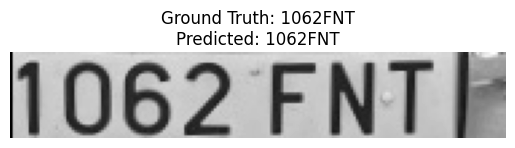

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\1062FNT_predicted.png
Processed Plate: 1062FNT (frontal) | Predicted: 1062FNT


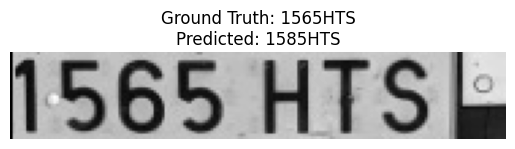

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\1565HTS_predicted.png
Processed Plate: 1565HTS (frontal) | Predicted: 1585HTS


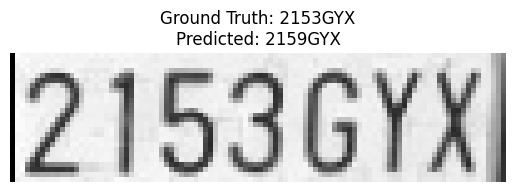

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\2153GYX_predicted.png
Processed Plate: 2153GYX (frontal) | Predicted: 2159GYX


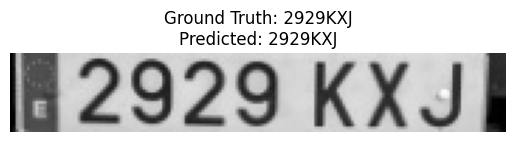

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\2929KXJ_predicted.png
Processed Plate: 2929KXJ (frontal) | Predicted: 2929KXJ


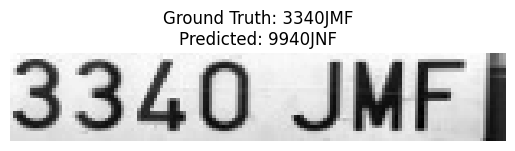

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\3340JMF_predicted.png
Processed Plate: 3340JMF (frontal) | Predicted: 9940JNF


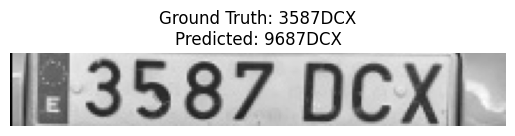

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\3587DCX_predicted.png
Processed Plate: 3587DCX (frontal) | Predicted: 9687DCX


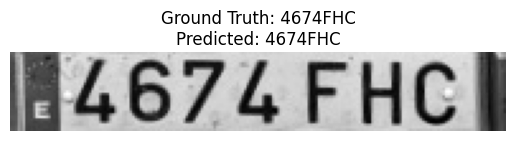

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\4674FHC_predicted.png
Processed Plate: 4674FHC (frontal) | Predicted: 4674FHC


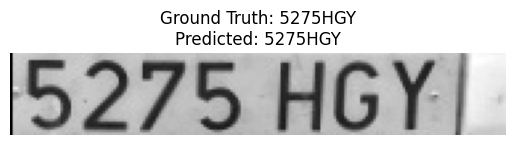

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\5275HGY_predicted.png
Processed Plate: 5275HGY (frontal) | Predicted: 5275HGY


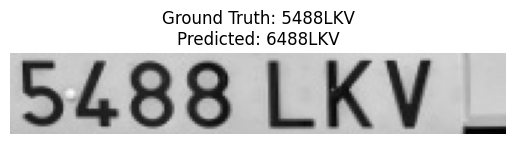

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\5488LKV_predicted.png
Processed Plate: 5488LKV (frontal) | Predicted: 6488LKV


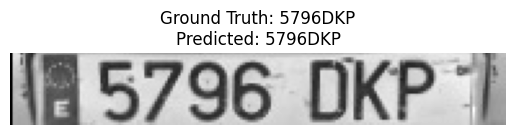

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\5796DKP_predicted.png
Processed Plate: 5796DKP (frontal) | Predicted: 5796DKP


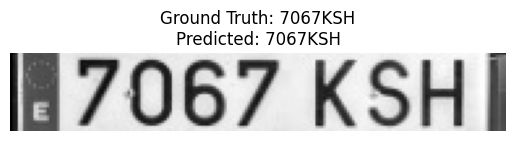

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\7067KSH_predicted.png
Processed Plate: 7067KSH (frontal) | Predicted: 7067KSH


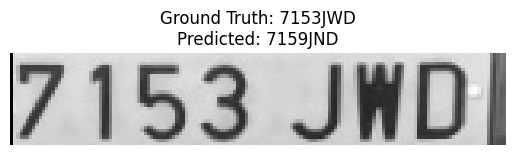

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\7153JWD_predicted.png
Processed Plate: 7153JWD (frontal) | Predicted: 7159JND


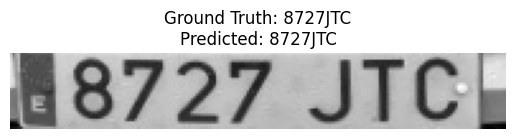

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\8727JTC_predicted.png
Processed Plate: 8727JTC (frontal) | Predicted: 8727JTC


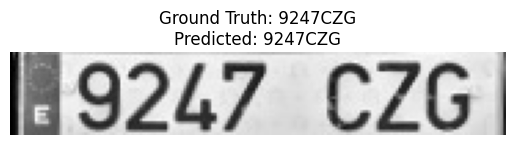

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\9247CZG_predicted.png
Processed Plate: 9247CZG (frontal) | Predicted: 9247CZG


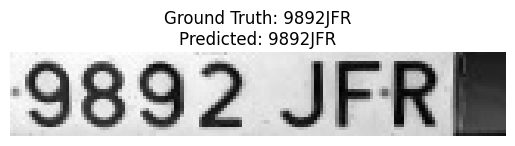

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\9892JFR_predicted.png
Processed Plate: 9892JFR (frontal) | Predicted: 9892JFR


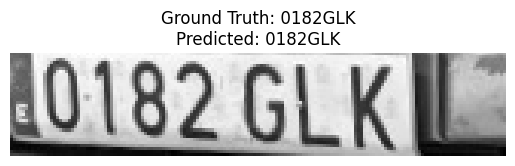

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\0182GLK_predicted.png
Processed Plate: 0182GLK (lateral) | Predicted: 0182GLK


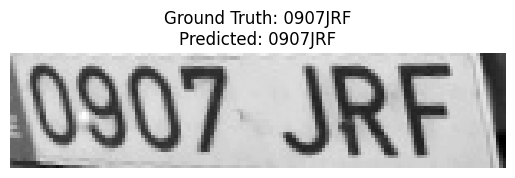

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\0907JRF_predicted.png
Processed Plate: 0907JRF (lateral) | Predicted: 0907JRF


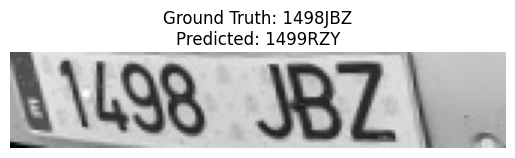

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\1498JBZ_predicted.png
Processed Plate: 1498JBZ (lateral) | Predicted: 1499RZY


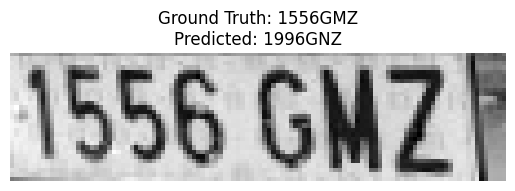

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\1556GMZ_predicted.png
Processed Plate: 1556GMZ (lateral) | Predicted: 1996GNZ


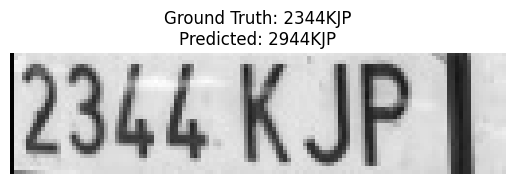

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\2344KJP_predicted.png
Processed Plate: 2344KJP (lateral) | Predicted: 2944KJP


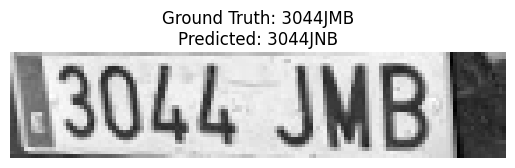

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\3044JMB_predicted.png
Processed Plate: 3044JMB (lateral) | Predicted: 3044JNB


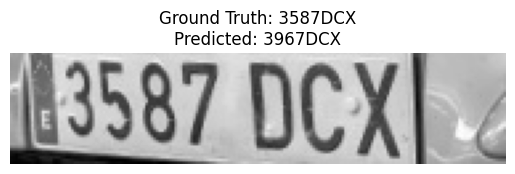

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\3587DCX_predicted.png
Processed Plate: 3587DCX (lateral) | Predicted: 3967DCX


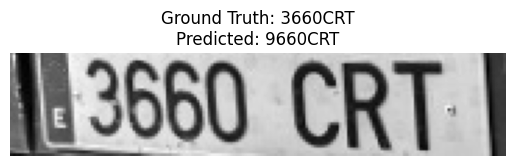

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\3660CRT_predicted.png
Processed Plate: 3660CRT (lateral) | Predicted: 9660CRT


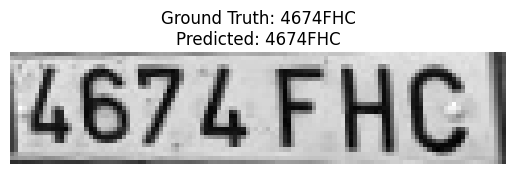

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\4674FHC_predicted.png
Processed Plate: 4674FHC (lateral) | Predicted: 4674FHC


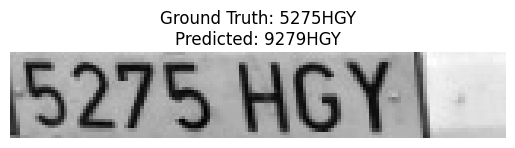

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\5275HGY_predicted.png
Processed Plate: 5275HGY (lateral) | Predicted: 9279HGY


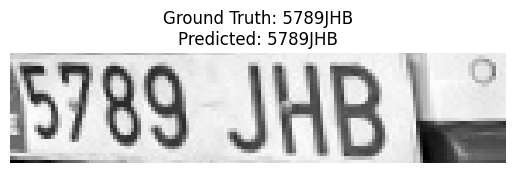

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\5789JHB_predicted.png
Processed Plate: 5789JHB (lateral) | Predicted: 5789JHB


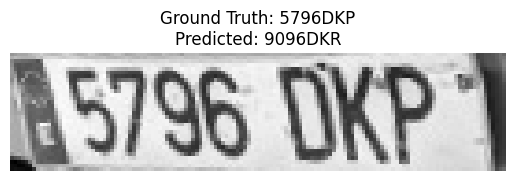

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\5796DKP_predicted.png
Processed Plate: 5796DKP (lateral) | Predicted: 9096DKR


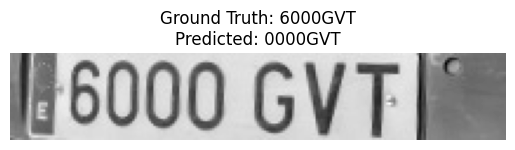

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\6000GVT_predicted.png
Processed Plate: 6000GVT (lateral) | Predicted: 0000GVT


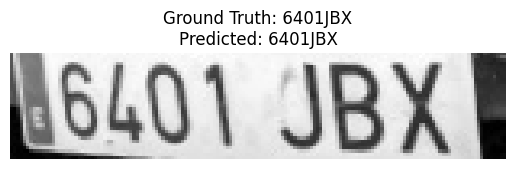

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\6401JBX_predicted.png
Processed Plate: 6401JBX (lateral) | Predicted: 6401JBX


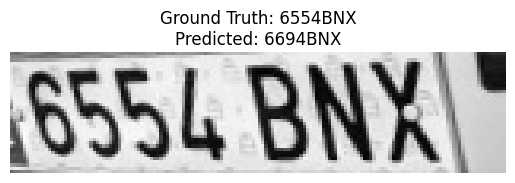

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\6554BNX_predicted.png
Processed Plate: 6554BNX (lateral) | Predicted: 6694BNX


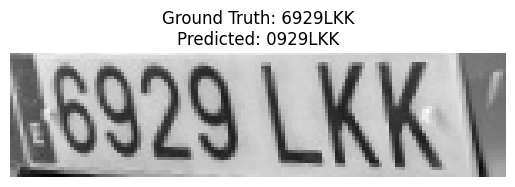

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\6929LKK_predicted.png
Processed Plate: 6929LKK (lateral) | Predicted: 0929LKK


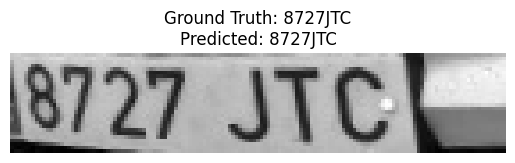

Saved visualization image: OCR_results/KNN/numbers_50_letters_1\8727JTC_predicted.png
Processed Plate: 8727JTC (lateral) | Predicted: 8727JTC

Results saved to OCR_results/KNN/numbers_50_letters_1\results.txt
Character-Level Accuracy: 86.16% (193 correct out of 224)
Numbers Accuracy: 82.03% (105 correct out of 128)
Letters Accuracy: 91.67% (88 correct out of 96)
License Plate Accuracy: 46.88% (15 correct out of 32)


In [123]:

"""#load the KNN models and label encoders
knn_model_numbers_path = 'knn_numbers_model.pkl'
knn_model_letters_path = 'knn_letters_model.pkl'
label_encoder_numbers_path = 'label_encoder_numbers.pkl'
label_encoder_letters_path = 'label_encoder_letters.pkl'

#load the KNN models
with open(knn_model_numbers_path, 'rb') as knn_file:
    knn_numbers_model = pickle.load(knn_file)

with open(knn_model_letters_path, 'rb') as knn_file:
    knn_letters_model = pickle.load(knn_file)

#load the label encoders
with open(label_encoder_numbers_path, 'rb') as encoder_file:
    label_encoder_numbers = pickle.load(encoder_file)

with open(label_encoder_letters_path, 'rb') as encoder_file:
    label_encoder_letters = pickle.load(encoder_file)"""

print("Models and Label Encoders loaded successfully.")

#set the paths to your dataset
plate_digits_folder = 'PlateDigits'
plate_images_folder = 'PlateImages'

#call the main function to process all plates
process_all_plates(
    plate_digits_folder, 
    plate_images_folder, 
    knn_numbers, 
    knn_letters, 
    label_encoder_numbers, 
    label_encoder_letters
)


## Visualization of the Results

These are some of the plots of the results

In [170]:
allowed_neighbors = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
letter_model_accuracies_neighbors = [91.67,90.62,90.62,91.67,89.58,90.62,88.54,85.42,85.42,85.42]
number_model_accuracies_neighbors = [81.25,79.69,82.03,81.25,80.47,82.81,80.47,82.03,82.03,82.03]

Plot saved to OCR_results/KNN


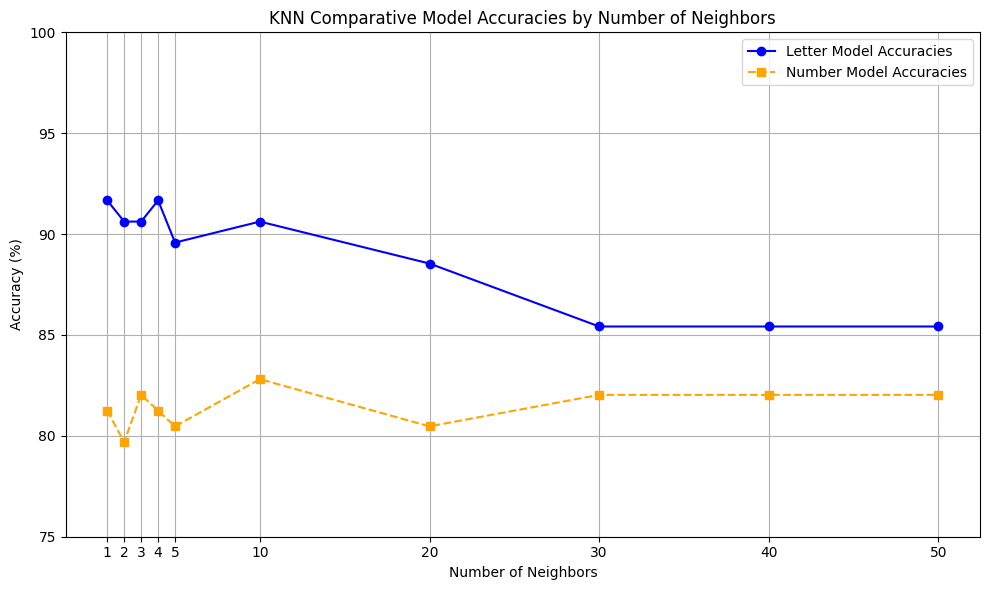

In [179]:
plt.figure(figsize=(10, 6))

# Plot for Letter Model Accuracies
plt.plot(allowed_neighbors, letter_model_accuracies_neighbors, marker='o', linestyle='-', color='blue', label='Letter Model Accuracies')

# Plot for Number Model Accuracies
plt.plot(allowed_neighbors, number_model_accuracies_neighbors, marker='s', linestyle='--', color='orange', label='Number Model Accuracies')

# Adding titles and labels
plt.title('KNN Comparative Model Accuracies by Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy (%)')
plt.xticks(allowed_neighbors)

# Set Y limits to create even spacing
plt.ylim(75, 100)  # Set limits from 75 to 100 for both models
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Optional: horizontal line at y=0 for reference

# Adding grid for better visibility
plt.grid(True)

# Add a legend to distinguish the lines
plt.legend()

# Save the plot to a file
output_directory = 'OCR_results/KNN'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist
plt.savefig(os.path.join(output_directory, 'KNN_Comparative_Model_Accuracies.png'), format='png', dpi=300)
print("Plot saved to OCR_results/KNN")

# Show the plot
plt.tight_layout()
plt.show()

In [175]:
print(f"Best accuracy for the letter model: {max(letter_model_accuracies_neighbors)}, with {allowed_neighbors[letter_model_accuracies_neighbors.index(max(letter_model_accuracies_neighbors))]} neighbors.")
print(f"Best accuracy for the Number model: {max(number_model_accuracies_neighbors)}, with {allowed_neighbors[number_model_accuracies_neighbors.index(max(number_model_accuracies_neighbors))]} neighbors.")

Best accuracy for the letter model: 91.67, with 1 neighbors.
Best accuracy for the letter model: 82.81, with 10 neighbors.
